```{eval-rst}
.. include:: ../sinebow.rst

```
{header-2}`The basics in 2D`
============================

This notebook demonstrates how to load images, display them, segment them using Omnipose, and visualize both the segmentation results and the intermediate network output. Here we show the details behind the most typical workflow: single-channel segmentation. The bacterial images used are (1) from my own image library and (2-5) from the DeLTA2.0 paper. From the latter, we shall see how to handle images that are intrinsically grayscale but were exported and published as RGB(A) - *i.e.*, there is no extra information in those extra channels to aid segmentation. For two-channel segmentation, see the `multi_channel_cyto` notebook. 

Before running this notebook, install the latest version of Omnipose from GitHub.

In [ ]:
# make local editable packages automatically reload
%load_ext autoreload
%autoreload 2
    

In [ ]:
# Import dependencies
import numpy as np
import omnipose

# set up plotting defaults
from omnipose.plot import imshow
omnipose.plot.setup()

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
from omnipose.gpu import use_gpu
use_GPU = use_gpu()

In [ ]:
# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')
%matplotlib inline

## How to load your images
There are several ways to load your image files into a notebook. If you have a specific set of images, put their full paths into a list. For example:
```python
# make it a list even if there is only one file
files = ['path_to_image_1'] 
files = ['path_to_image_1','path_to_image_2']

# you can also add to the list like so:
files = files + ['path_to_image_3']
```

Alternatively, you can load all the images in a directory. Here are a few templates you can use to get the list of directories automatically by searching for image files matching a cetrain file lane with an extension and keywords in the file name. 
```python
from pathlib import Path

basedir = '<path_to_image_folder>'
# use rglob to search subfolders recursively 
files = [str(p) for p in Path(basedir).rglob("*.tif")] 
# change the search string to grab only one channel
files = [str(p) for p in Path(basedir).glob("*C1.png")]
# specify a match anywhere in the file name
files = [str(p) for p in Path(basedir).glob("*488*.png")] 
```

We can also use the {mod}`cellpose_omni.io` library to grab all the images in the test_files folder. This is very handy for grabbing images of different extensions. Here we are using  four RGB(A) images from the DeLTA 2.0 training set (on which the bact_phase_omni model has never been trained) as well as an RGB image acquired in the same lab as much of the Omnipose `bact_phase` dataset. 

In [ ]:
from pathlib import Path
import os
from cellpose_omni import io
import omnipose
omnidir = Path(omnipose.__file__).parent.parent.parent
basedir = os.path.join(omnidir,'docs','test_files')
files = io.get_image_files(basedir)

Next we read in the images from the file list. It's a good idea to display the images before proceeding. Here I happen to be reading in some RBG tiles of grayscale phase contrast images (such as you might use for figures etc.) as well as some single-channel images. As part of the visualization process, the images are rescaled to be in the range 0-1. Omnipose does this exact thing internally (you don't have to rescale them prior to running segmentation via CLI). 

Original image shape: (287, 377, 4)
data type: uint8
data range: min 4, max 255

Original image shape: (564, 564, 3)
data type: uint8
data range: min 30, max 203

Original image shape: (783, 908)
data type: uint8
data range: min 0, max 255

Original image shape: (396, 390, 4)
data type: uint8
data range: min 49, max 255

Original image shape: (281, 310)
data type: uint16
data range: min 360, max 64813

Original image shape: (384, 392)
data type: uint16
data range: min 0, max 65535

Original image shape: (334, 321)
data type: uint16
data range: min 2582, max 39614


number of images: 7


new shape:  (287, 377)
new shape:  (564, 564)
new shape:  (783, 908)
new shape:  (396, 390)
new shape:  (281, 310)
new shape:  (384, 392)
new shape:  (334, 321)


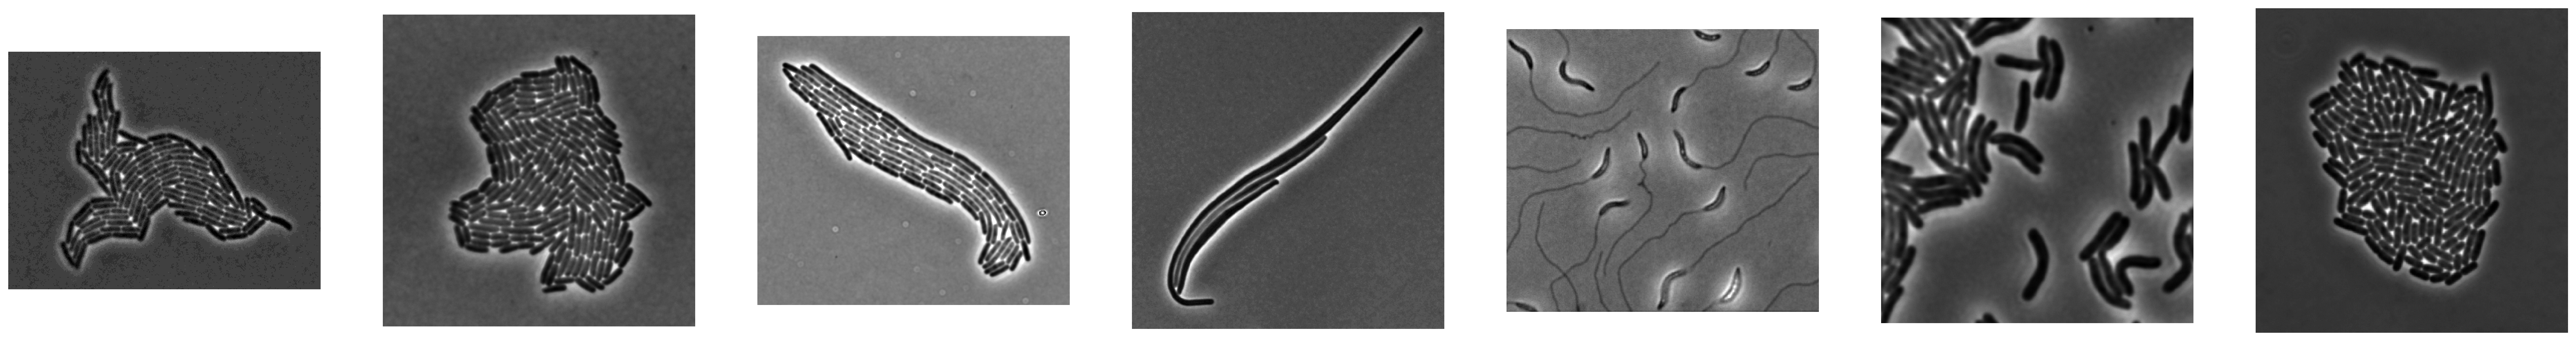

In [ ]:
from cellpose_omni import io, transforms
from omnipose.utils import normalize99
imgs = [io.imread(f) for f in files]

# print some info about the images.
for i in imgs:
    print('Original image shape:',i.shape)
    print('data type:',i.dtype)
    print('data range: min {}, max {}\n'.format(i.min(),i.max()))
nimg = len(imgs)
print('\nnumber of images:',nimg)

fig = plt.figure(figsize=[40]*2,frameon=False) # initialize figure
print('\n')
for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        # imgs[k] = img[:,:,1] # could pick out a specific channel
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
        
    imgs[k] = normalize99(imgs[k])
    # imgs[k] = np.pad(imgs[k],10,'edge')
    print('new shape: ', imgs[k].shape)
    plt.subplot(1,len(files),k+1)
    plt.imshow(imgs[k],cmap='gray')
    plt.axis('off')

Note that the first two images are RGB, the third and fifth are mono-channel, and the fourth is RGBA (the alpha channel encodes transparency). Exporting to RGB is usually just done for making diagrams or making images compatible with non-scientific viewing software. Pro tip: Adobe Illustrator *will not* interpolate the pixels in your image if you save it as RGB, but it *will* if you keep it mono-channel. Usually you want exact, non-interpolated (pixelated) images to be presented since it is your raw data, so you can convert it to grayscale by `im_RGB = [im,im,im]` (or more slick, `im_RGB = [im,]*3` or `*4` for RGBA). However, storing *all* your images this way is a waste of space - just do it for the ones you need for a figure. 

Also note that the DeLTA images (1-4) are uint8, so `0` to `2**8-1 = 255`. Image 1 only takes up values in the range 4 to 22 out of a possible 0 to 255, meaning it was probably way too dark and not rescaled prior to conversion to an 8-bit image. In my experience, images are typically 14-bit (that depends on your camera) and therefore saved as 16-bit lossless formats like PNG or TIF (Omnipose can detect and segment JPEGs, but you would never use those for anything scientific, even for figures due to compression artifacts). Using only `22-4 = 18` levels of gray to depict the cells causes the distinct 'posterized' effect that you can see if you zoom up on the image. 


## Initialize model
Here we use one of the built-in model names. You can print out the available model names, too:

In [ ]:
import cellpose_omni
from cellpose_omni import models
from cellpose_omni.models import MODEL_NAMES

MODEL_NAMES

['bact_phase_affinity',
 'bact_phase_omni',
 'bact_fluor_omni',
 'worm_omni',
 'worm_bact_omni',
 'worm_high_res_omni',
 'cyto2_omni',
 'plant_omni',
 'bact_phase_cp',
 'bact_fluor_cp',
 'plant_cp',
 'worm_cp',
 'cyto',
 'nuclei',
 'cyto2']

We will choose the newer `bact_phase_affinity` model. 

In [ ]:
model_name = 'bact_phase_affinity'
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

2025-07-24 16:07:18,463	[INFO]     cellpose_omni/models.py       __init__....()	 line 436	>>bact_phase_affinity<< model set to be used
2025-07-24 16:07:18,465	[INFO]     cellpose_omni/core.py         assi...evice()	 line  67	Using GPU.
2025-07-24 16:07:18,572	[INFO]                                   __init__....()	 line 173	u-net config: ([1, 32, 64, 128, 256], 3, 2)


## Run segmentation 

In [ ]:
import time
n = [-1] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
params = {'channels':None, # always define this if using older models, e.g. [0,0] with bact_phase_omni
          'rescale': None, # upscale or downscale your images, None = no rescaling 
          'mask_threshold': -2, # erode or dilate masks with higher or lower values between -5 and 5 
          'flow_threshold': 0, # default is .4, but only needed if there are spurious masks to clean up; slows down output
          'transparency': True, # transparency in flow output
          'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
          'cluster': True, # use DBSCAN clustering
          'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
          'verbose': False, # turn on if you want to see more output 
          'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
          'niter': None, # default None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
          'augment': False, # Can optionally rotate the image and average network outputs, usually not needed 
          'affinity_seg': True, # new feature, stay tuned...
         }

tic = time.time() 
masks, flows, styles = model.eval([imgs[i] for i in n],**params)

net_time = time.time() - tic

print('total segmentation time: {}s'.format(net_time))

  0%|          | 0/7 [00:00<?, ?it/s]

total segmentation time: 5.486669063568115s


Note that since some functions require just-in-time numba compilation, the first round of segmentation will be slightly slower than subsequent runs. 

## Plot the results

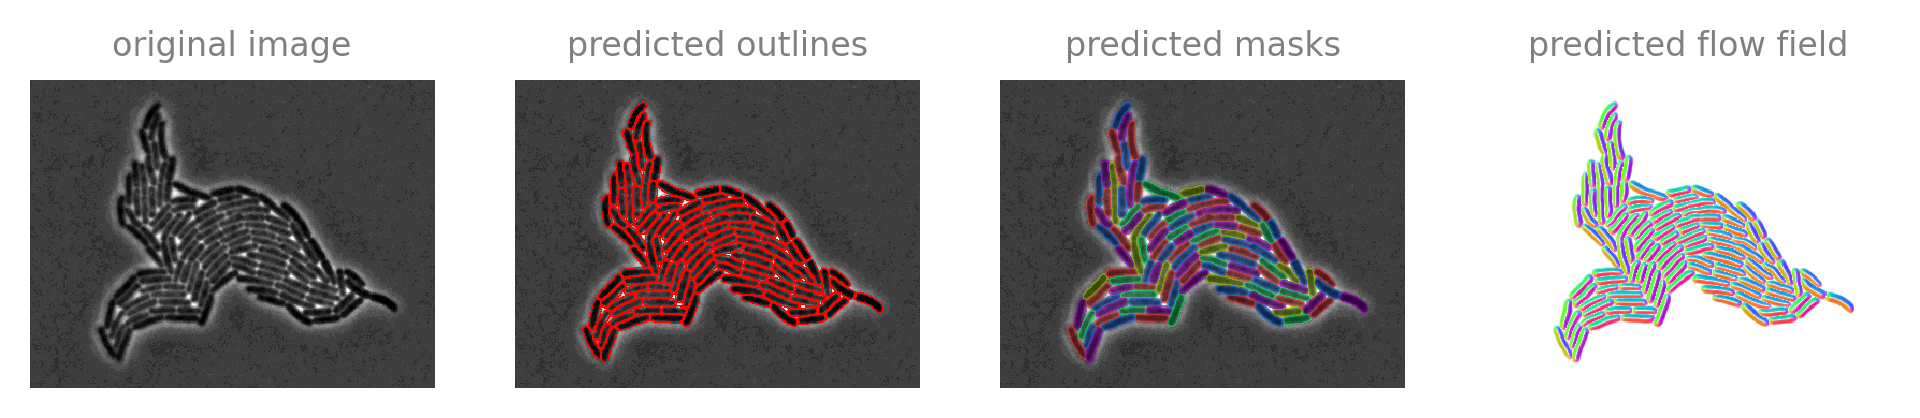

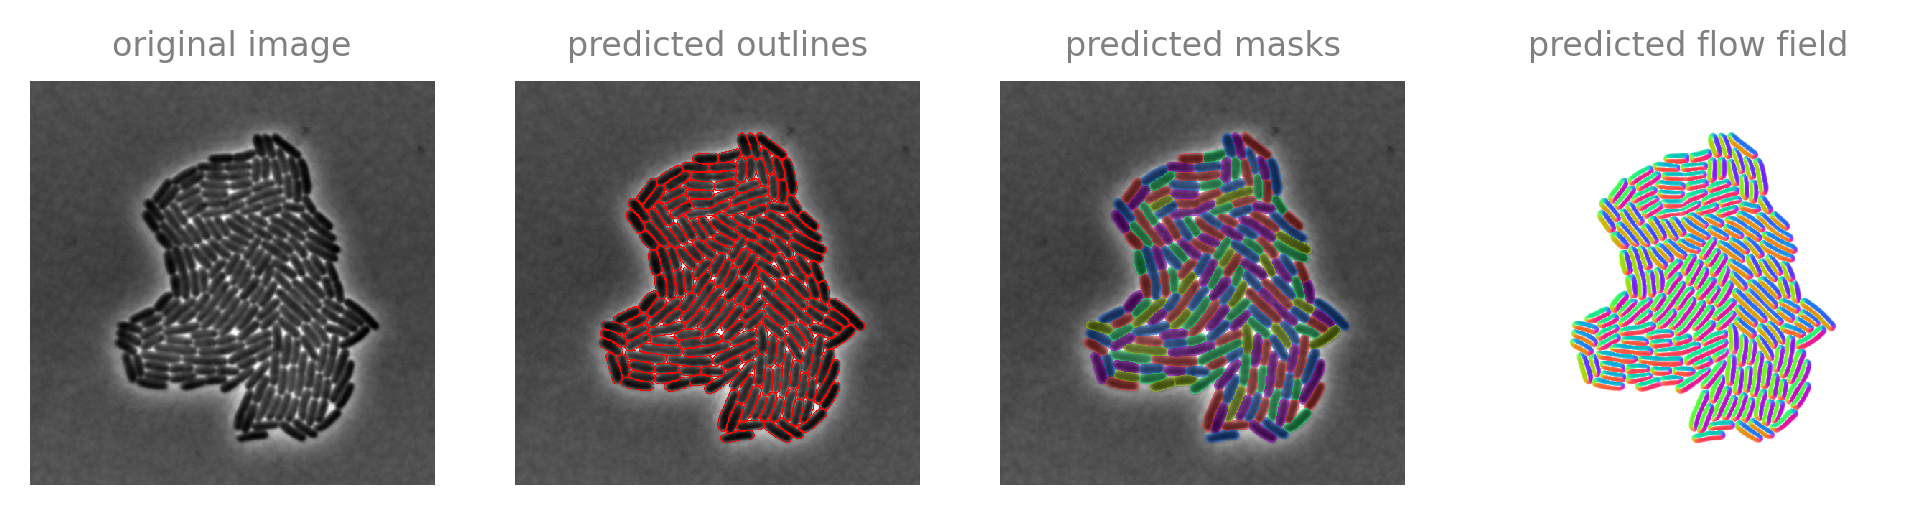

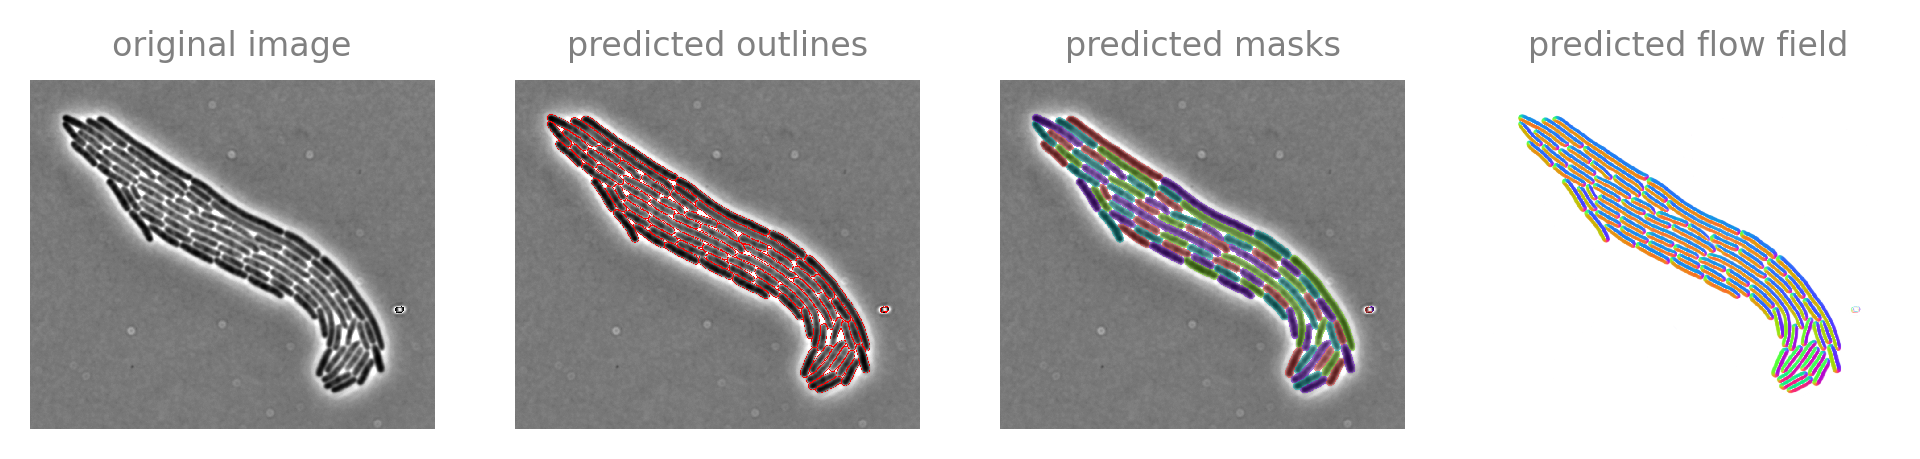

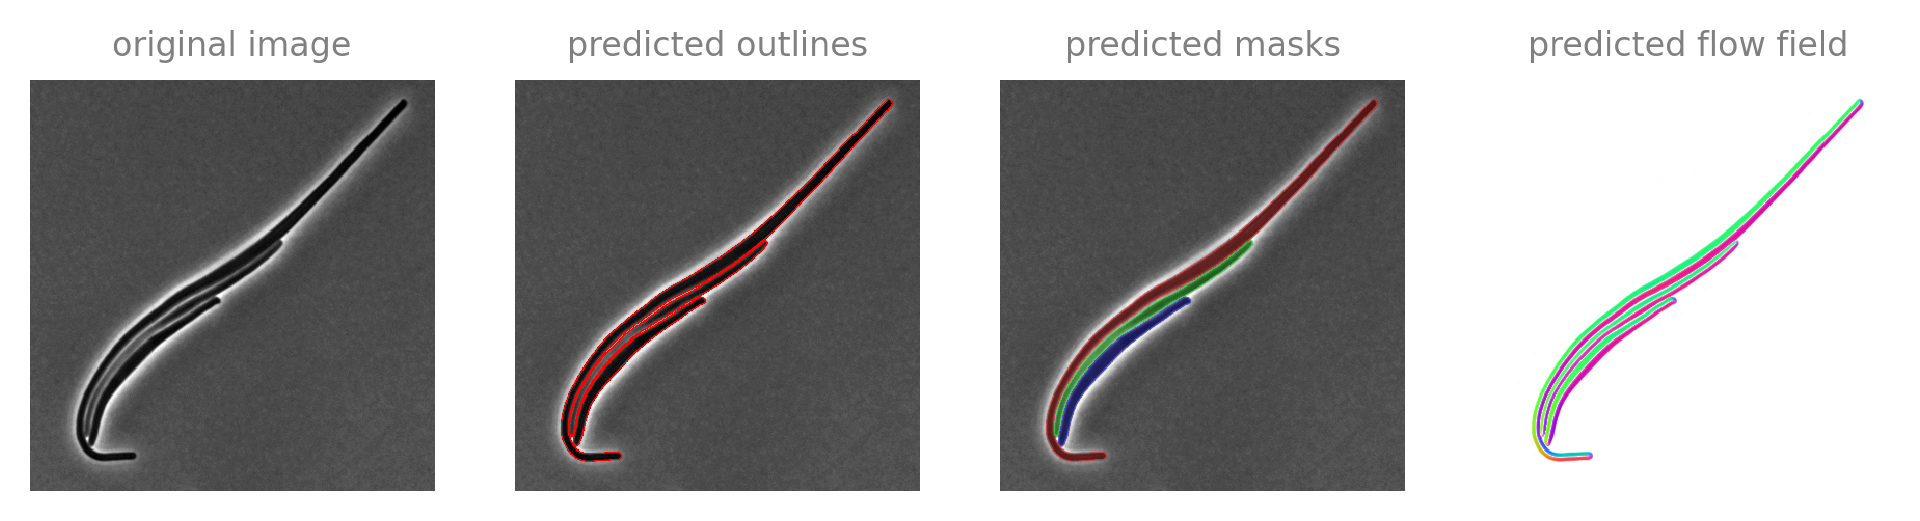

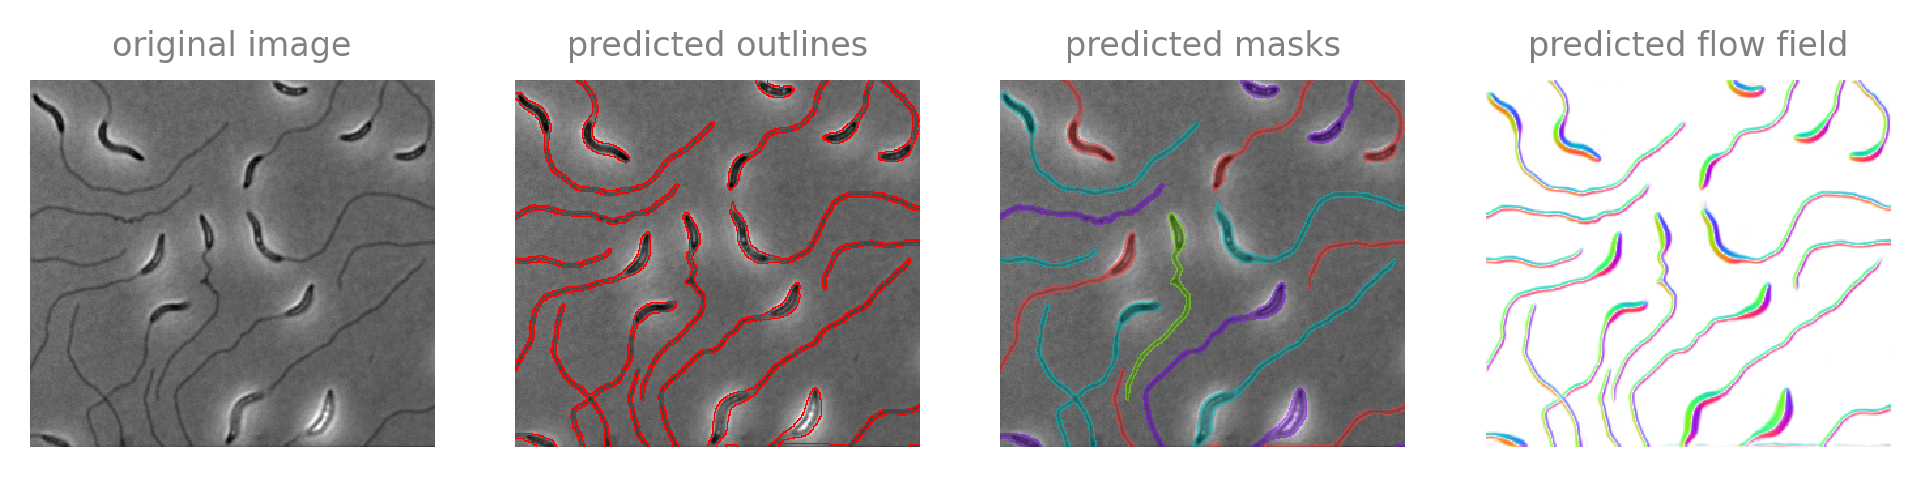

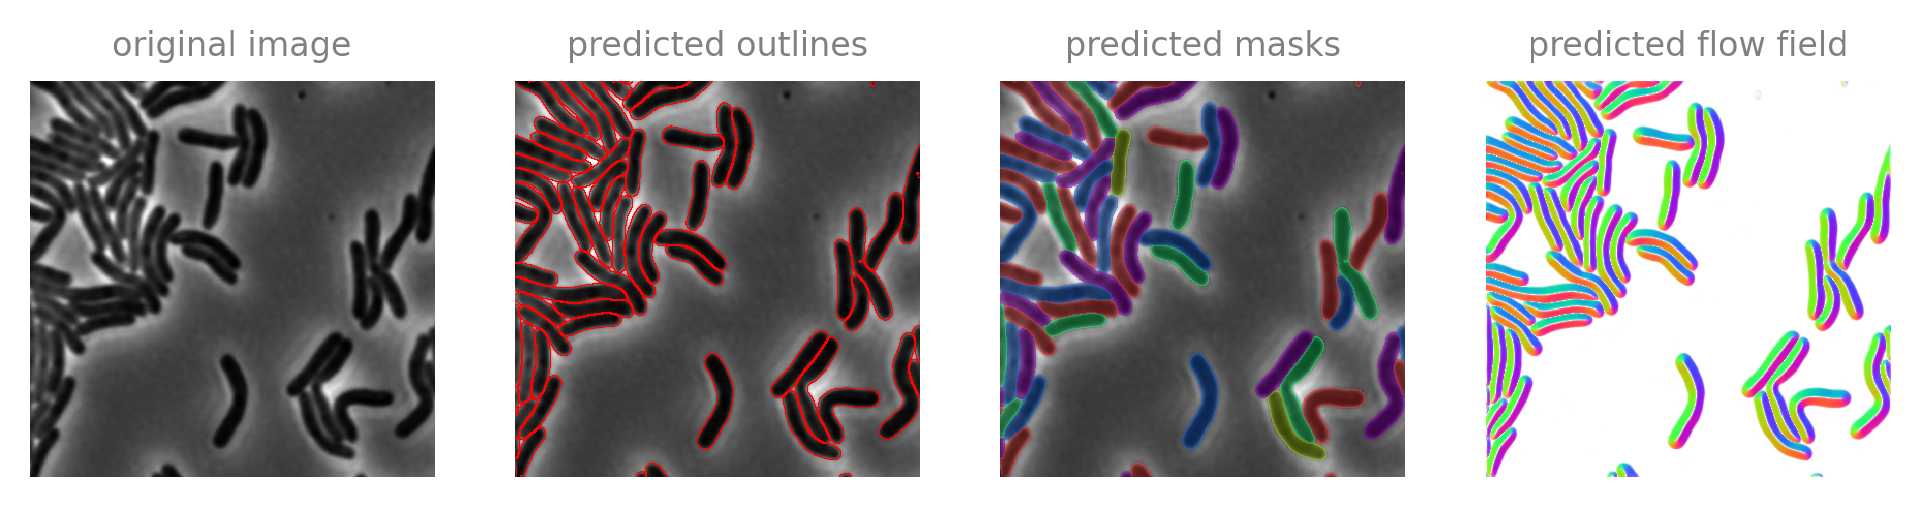

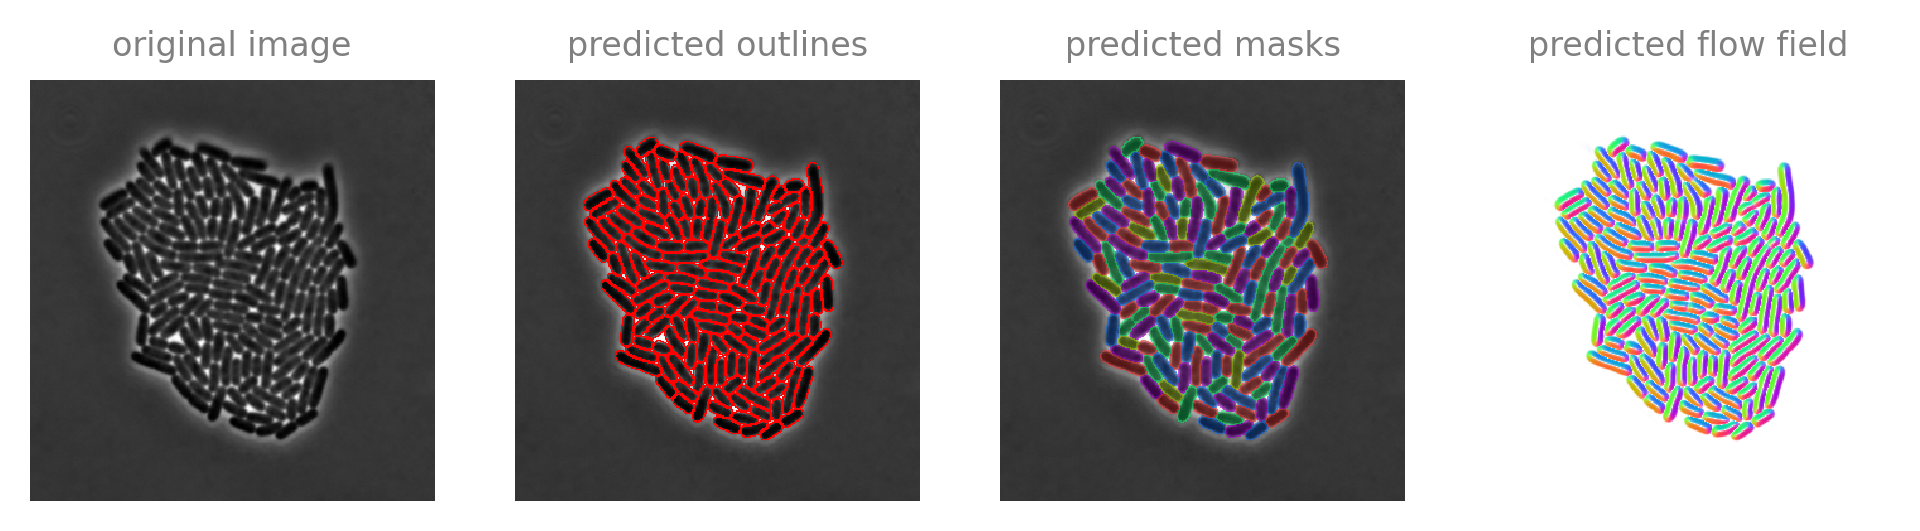

In [ ]:
from cellpose_omni import plot
import omnipose

for idx,i in enumerate(n):

    maski = masks[idx] # get masks
    bdi = flows[idx][-1] # get boundaries
    flowi = flows[idx][0] # get RGB flows 

    # set up the output figure to better match the resolution of the images 
    f = 15
    szX = maski.shape[-1]/mpl.rcParams['figure.dpi']*f
    szY = maski.shape[-2]/mpl.rcParams['figure.dpi']*f
    fig, ax = omnipose.plot.figure(figsize=(szY,szX*4), facecolor=[0]*4, frameon=False)
    
    plot.show_segmentation(fig, omnipose.utils.normalize99(imgs[i]), 
                           maski, flowi, bdi, channels=None, omni=True,
                           interpolation=None)


## Save the results
Often you will want to save your masks before moving on to analysis (that way to can just load them in instead of re-running segmentation). I improved the `cellpose.io` function quite a bit to be more flexible in where it can save. See the documentation page for the full list of options. 

In [ ]:
io.save_masks(imgs, masks, flows, files, 
              png=False,
              tif=True, # whether to use PNG or TIF format
              suffix='', # suffix to add to files if needed 
              save_flows=False, # saves both RGB depiction as *_flows.png and the raw components as *_dP.tif
              save_outlines=False, # save outline images 
              dir_above=0, # save output in the image directory or in the directory above (at the level of the image directory)
              in_folders=True, # save output in folders (recommended)
              save_txt=False, # txt file for outlines in imageJ
              save_ncolor=False) # save ncolor version of masks for visualization and editing 

## Debug results

The RGB flows shown above will give you some insight as to if there is an issue with the flow field outputs, but you can also check out the boundary and distance output:

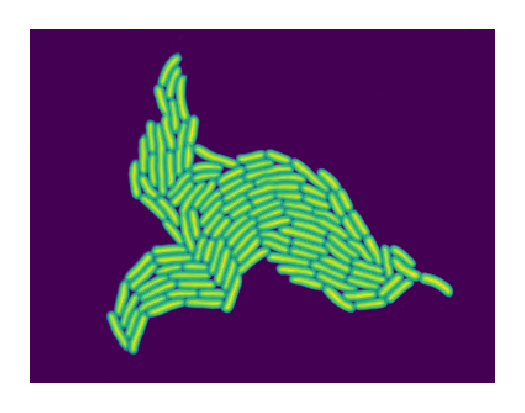

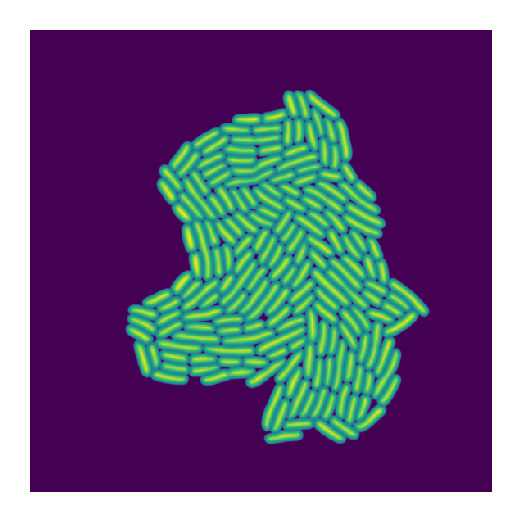

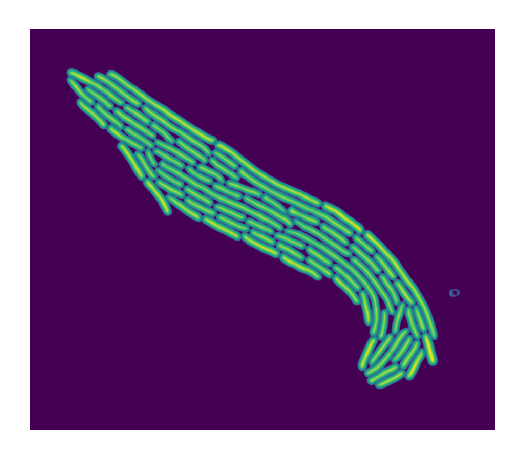

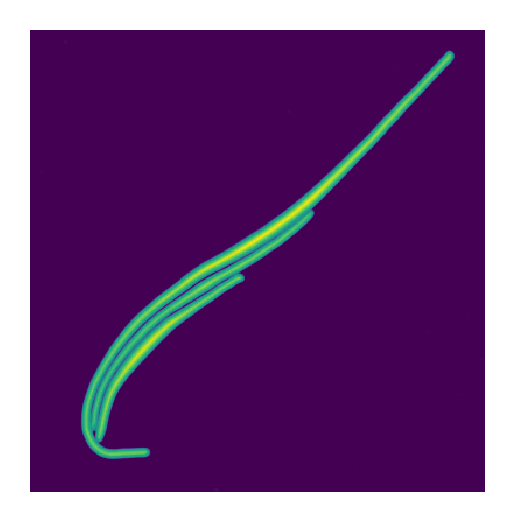

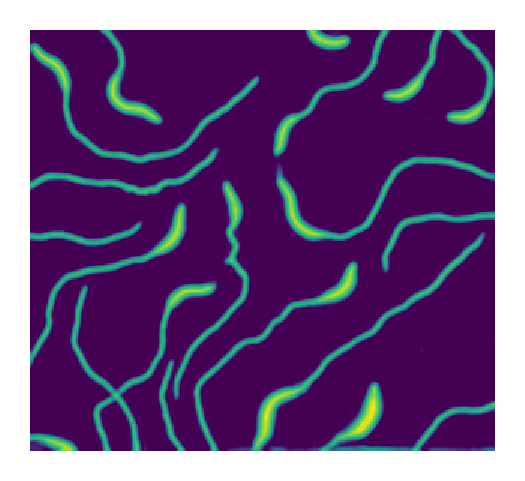

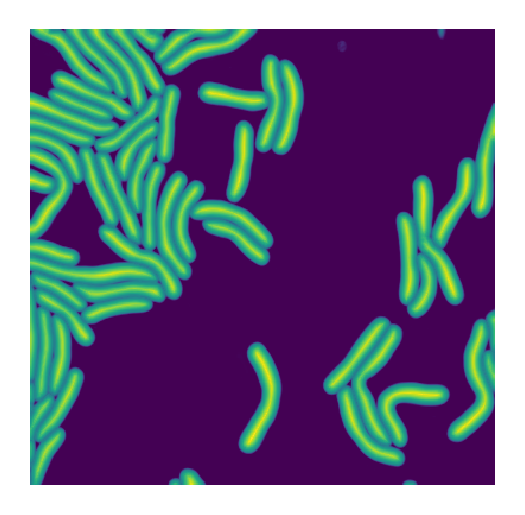

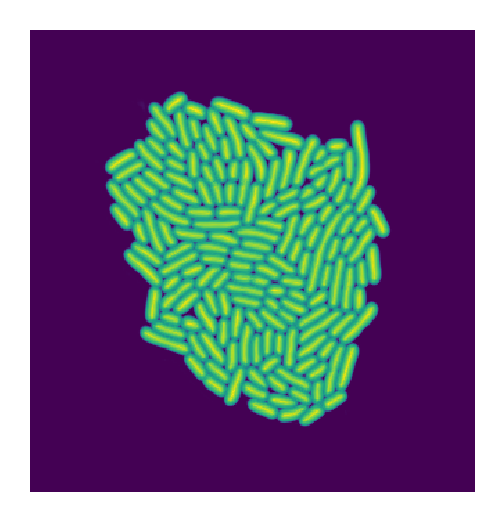

In [ ]:
for idx,i in enumerate(n):

    disti = flows[idx][2] # distance field prediction
    imshow(disti, 2, cmap='viridis')

### Notes on the above
The distance field is trained with background pixels set to `-5` in older models and `-<mean diameter>` in newer models. This helps to make the desired network output more balanced and give more distinction between edge pixels (which have values close to 0) and background (which ordinarily would have a value of 0). The flow field, being the gradient of the distance field, *by definition* has a magnitude of 1 everywhere - but we rescale it by `5` for training. This helps by bringing the desired flow component output more in the range of the boundary output, which is the input to the sigmoid function (so-called 'logits') and therefore ranges from about `-5` to `5`. 

What you can see in the images above is that the features in the boundary, distance, and flow fields are all very consistent with each other. For example, the flow field has positive divergence where the boundary output is high and negative divergence where the distance field is high. This is by design, as I included the boundary field for the sole purpose of improving the prediction accuracy on the flow and distance fields. 